# What is the contribution of paralogs to SL pairs that share protein domains?

In [1]:
from intermine.webservice import Service
import numpy as np
import scipy.io
import seaborn as sns
from scipy import stats, optimize, interpolate
import pandas as pd
from collections import defaultdict 
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import stats
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import os, fnmatch

In [2]:
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_sl="datasets/data-synthetic-lethals.xlsx"
rel_path_paralogs='datasets/paralogs-all-unique-SL-pairs.xlsx'

abs_file_path_sl = os.path.join(script_dir, rel_path_sl)
abs_file_path_paralogs = os.path.join(script_dir, rel_path_paralogs)

# os.chdir('../') #<-- for binder os.chdir('../')

data_sl=pd.read_excel(abs_file_path_sl,header=0)
all_paralogs_from_sl=pd.read_excel(abs_file_path_paralogs)

##  Inspecting the paralogs pairs

- this is the first check to analyze if the reason why a SL pair shares domains is because they are also paralogs.

In [3]:
query_paralogs_pd=all_paralogs_from_sl.drop(columns='Unnamed: 0')
query_paralogs_pd.columns=['name-gene','name-paralogue']
query_paralogs_pd_withoutnan=query_paralogs_pd.dropna()
query_paralogs_pd_withoutnan.index=np.arange(0,len(query_paralogs_pd_withoutnan))
query_paralogs_pd=query_paralogs_pd_withoutnan

#### Taking the indexes of the paralogs pairs that are also synthetic lethal

In [4]:
indexes_sl_query=[]

for i in np.arange(0,len(query_paralogs_pd)):
    paralog_target=query_paralogs_pd[query_paralogs_pd['name-gene']==query_paralogs_pd['name-gene'][i]]['name-paralogue'].tolist()[0]
    list_targets_sl=data_sl[data_sl['gene-query-name']==query_paralogs_pd['name-gene'][i]]['gene-target-name'].tolist()


    
    if paralog_target in list_targets_sl:
        indexes_sl_query.append(query_paralogs_pd[query_paralogs_pd['name-paralogue']==paralog_target].index[0])


### Putting 1's if the paralog pair is also SL

In [5]:
sL_values=np.zeros_like(query_paralogs_pd['name-gene'])
for i in np.arange(0,len(query_paralogs_pd)):
    if i in indexes_sl_query:
        sL_values[i]=1
query_paralogs_pd['sL']=sL_values

paralogs_sl_pd=query_paralogs_pd

In [6]:
sl_that_are_paralogs=paralogs_sl_pd[paralogs_sl_pd['sL']==1]
sl_that_are_paralogs.head()

,name-gene,name-paralogue,sL
2,ADE16,ADE17,1
6,AFT1,AFT2,1
8,AGA1,FIG2,1
11,AIR1,AIR2,1
16,ALP1,CAN1,1


In [7]:
sl_that_are_paralogs.set_index(np.arange(0,len(sl_that_are_paralogs)))

,name-gene,name-paralogue,sL
0,ADE16,ADE17,1
1,AFT1,AFT2,1
2,AGA1,FIG2,1
3,AIR1,AIR2,1
4,ALP1,CAN1,1
...,...,...,...
171,YCK1,YCK2,1
172,YPC1,YDC1,1
173,YPK1,YPK2,1
174,YPS1,MKC7,1


## What is the contribution of paralogs to SL that share protein domains?

In [8]:
pairs_sL=np.load('pairs-sL-that-share-domains.npy')

In [9]:
shared_sL_paralogs=[]
for i in np.arange(0,len(sl_that_are_paralogs)):
    for j in np.arange(0,len(pairs_sL)):
        if set(sl_that_are_paralogs.iloc[i,0:2].tolist())==set(pairs_sL[j]):
            shared_sL_paralogs.append(pairs_sL[j])


In [10]:
print('The contribution of paralogs to the SL pairs that shared domains is =', 100*len(shared_sL_paralogs)/len(pairs_sL),'%')
print('Only',len(shared_sL_paralogs),'out of',len(sl_that_are_paralogs),'paralogs that are SL , share annotated protein domains.')

print('The number of paralogs that are SL out of the total number of paralogs is',len(sl_that_are_paralogs),'out of',len(paralogs_sl_pd),'=',100*len(sl_that_are_paralogs)/len(paralogs_sl_pd),'%')

print('The contribution of paralogs to the total number of SL pairs is  =', 100*len(sl_that_are_paralogs)/17871,'%')
print('The number of SL that share domains out of the total number of SL pairs is =',100*len(pairs_sL)/17871,'%')

The contribution of paralogs to the SL pairs that shared domains is = 1.6042780748663101 %
Only 12 out of 176 paralogs that are SL , share annotated protein domains.
The number of paralogs that are SL out of the total number of paralogs is 176 out of 720 = 24.444444444444443 %
The contribution of paralogs to the total number of SL pairs is  = 0.9848357674444631 %
The number of SL that share domains out of the total number of SL pairs is = 4.185552011638968 %


In [11]:
# Pie chart
labels = ['SL-paralogs','Paralogs non SL']
sizes = [len(sl_that_are_paralogs)/len(paralogs_sl_pd),len(paralogs_sl_pd)/len(paralogs_sl_pd)-len(sl_that_are_paralogs)/len(paralogs_sl_pd)]

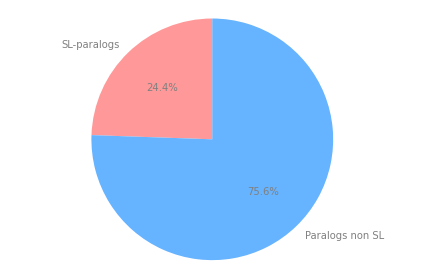

In [12]:
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()